# Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.covariance import EmpiricalCovariance, LedoitWolf

import covariance_DRO

sns.set(rc={'figure.figsize':(8,4)})

import warnings
warnings.filterwarnings("ignore")

# Eigenvalue and Condition Number Path

In [2]:
def plot_ev_cn_path(eigs, method, epsilons = np.arange(0.1, 3, 0.1)):
    eigenvalues = []
    K = []
    sigma_hat = np.diag(eigs)
    for e in epsilons:
        sigma_star = covariance_DRO.estimate_cov(sigma_hat, e, method)
        w, v = np.linalg.eig(sigma_star)
        eigenvalues.append(w)
        K.append(w.max()/w.min())
    eigenvalues = np.vstack(eigenvalues)
    fig, axs = plt.subplots(1,2, figsize=(16,8))
    for i, e in enumerate(eigs):
        sns.lineplot(x=epsilons, y=eigenvalues[:,i], ax=axs[0])
        axs[0].set_title('Eigenvalue Path')
        axs[0].set_xlabel('Ball Radius')
        axs[0].set_ylabel('Eigenvalue')
    sns.lineplot(x=epsilons, y=K, ax=axs[1])
    axs[1].set_title('Condition Number Path')
    axs[1].set_xlabel('Ball Radius')
    axs[1].set_ylabel('Condition Number')
    return eigenvalues, K, axs

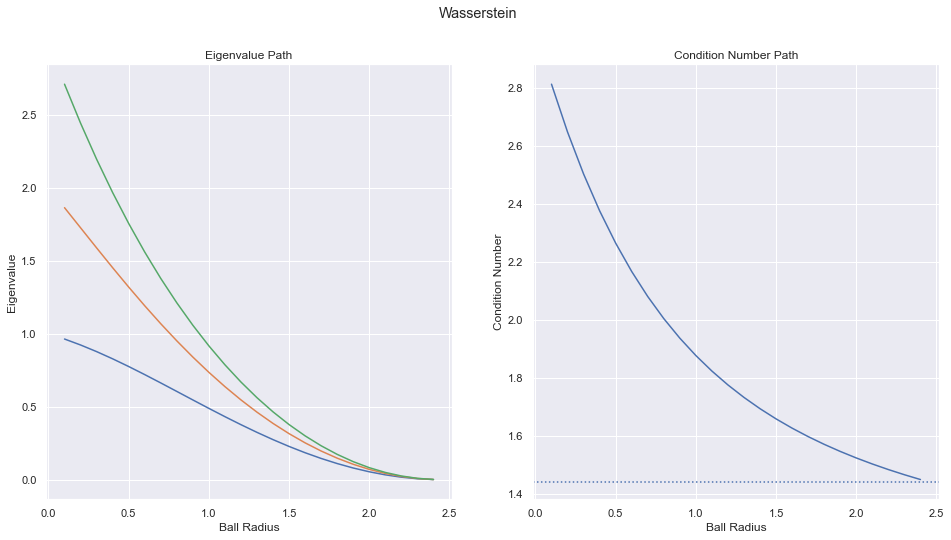

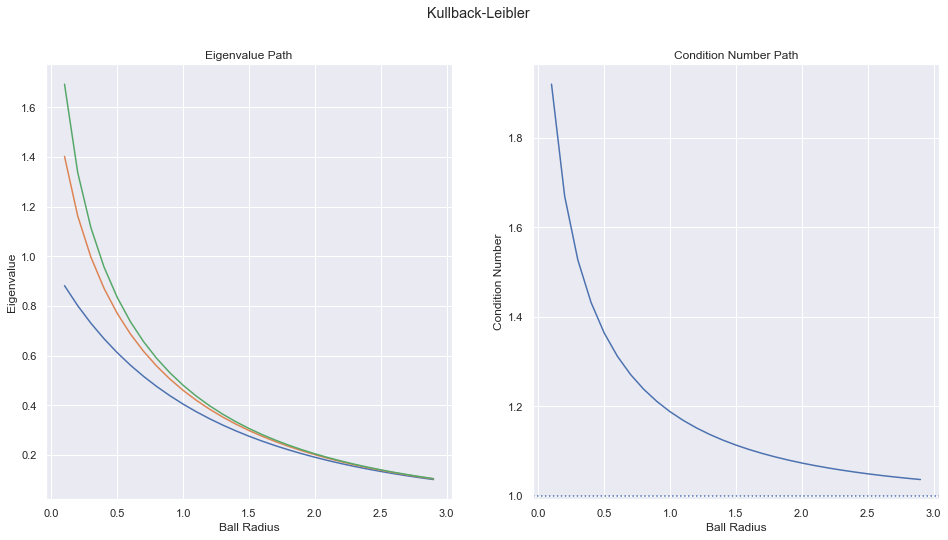

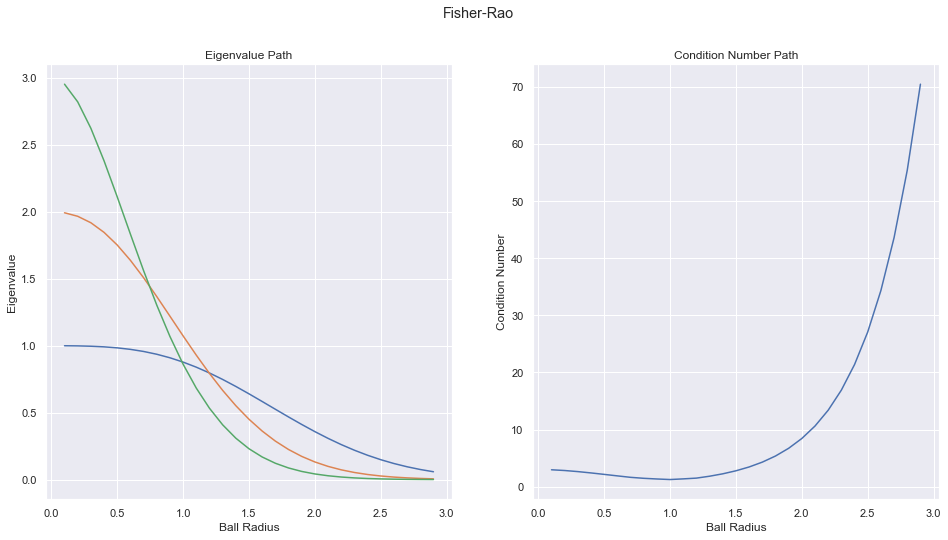

In [3]:
eigenvalues, K, axs = plot_ev_cn_path([1,2,3], 'Wasserstein', epsilons = np.arange(0.1, np.sqrt(6), 0.1))
axs[1].axhline(np.cbrt(3),ls=':')
plt.suptitle('Wasserstein');

eigenvalues, K, axs = plot_ev_cn_path([1,2,3], 'KLdirect', epsilons = np.arange(0.1, 3, 0.1))
axs[1].axhline(1,ls=':')
plt.suptitle('Kullback-Leibler');

eigenvalues, K, axs = plot_ev_cn_path([1,2,3], 'Fisher-Rao', epsilons = np.arange(0.1, 3, 0.1))
plt.suptitle('Fisher-Rao');

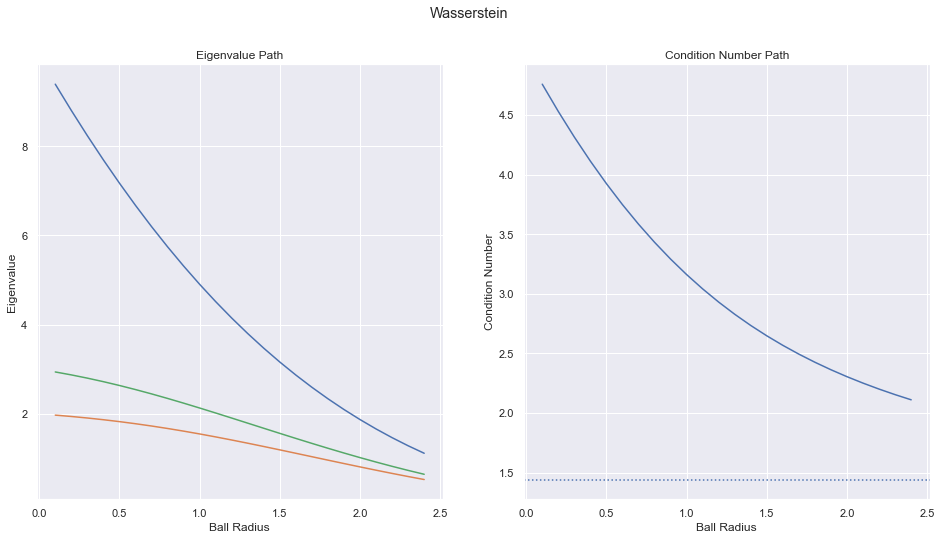

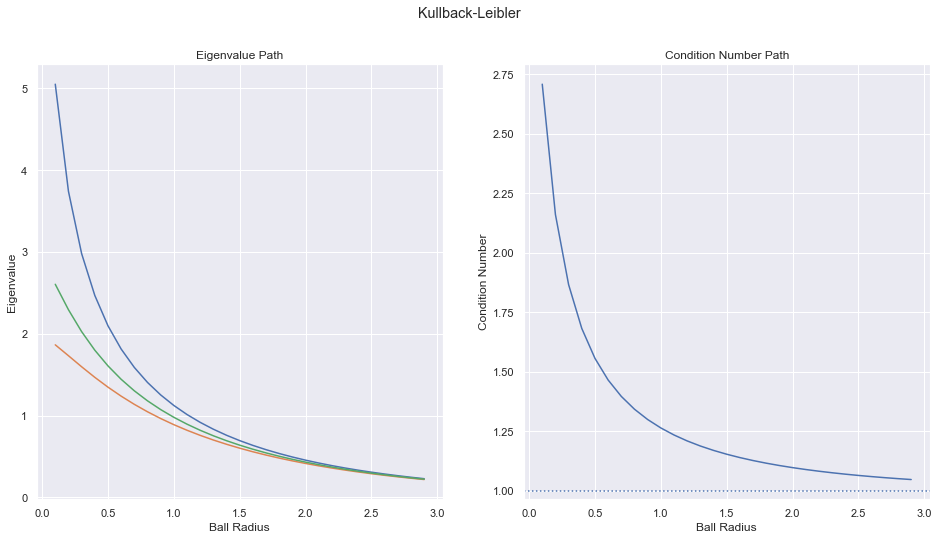

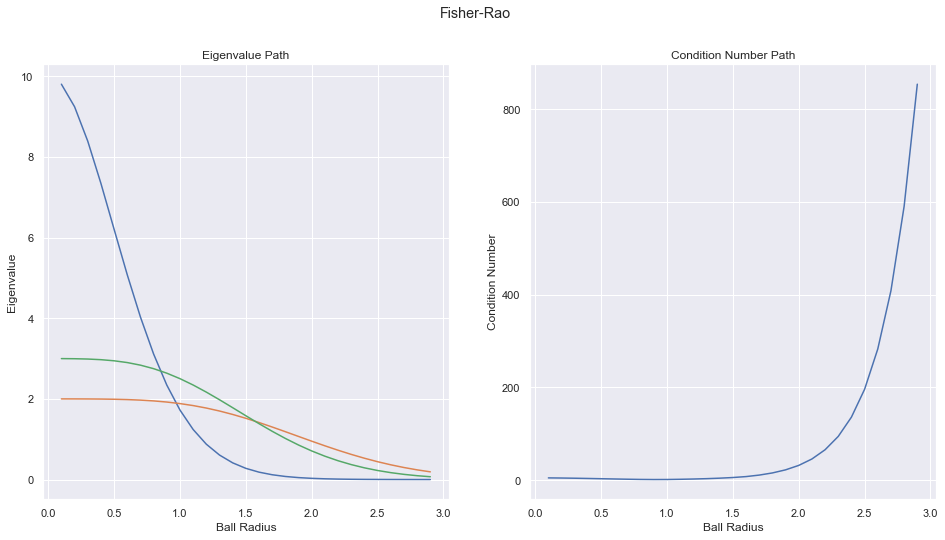

In [4]:
eigenvalues, K, axs = plot_ev_cn_path([10,2,3], 'Wasserstein', epsilons = np.arange(0.1, np.sqrt(6), 0.1))
axs[1].axhline(np.cbrt(3),ls=':')
plt.suptitle('Wasserstein');

eigenvalues, K, axs = plot_ev_cn_path([10,2,3], 'KLdirect', epsilons = np.arange(0.1, 3, 0.1))
axs[1].axhline(1,ls=':')
plt.suptitle('Kullback-Leibler');

eigenvalues, K, axs = plot_ev_cn_path([10,2,3], 'Fisher-Rao', epsilons = np.arange(0.1, 3, 0.1))
plt.suptitle('Fisher-Rao');